In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from keras.metrics import MeanSquaredError
import pickle

print("Keras backend:", K.backend())


Keras backend: tensorflow


In [2]:
# Read the data 
df = pd.read_csv("NVidia_stock_history.csv")
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Set de antrenare: anii 2022 și 2023
train = df[(df['Date'].dt.year >= 2022) & (df['Date'].dt.year <= 2023)]

# Set de testare: anul 2024
test = df[df['Date'].dt.year == 2024]

train_data = train['Volume'].values
test_data = test['Volume'].values

In [3]:
# Create train and test data
def create_data(train_data, test_data, sequence_length):

    overlap_data = train_data[-sequence_length:]
    test_data = np.concatenate([overlap_data, test_data])
    
    train_data = train_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)

    std_scaler = StandardScaler()
    train_data = std_scaler.fit_transform(train_data)
    test_data = std_scaler.transform(test_data)
    
    X_train, y_train = [], []
    for i in range(len(train_data) - sequence_length):
        X_train.append(train_data[i : i + sequence_length])
        y_train.append(train_data[i + sequence_length])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_test, y_test = [], []
    for i in range(len(test_data) - sequence_length):
        X_test.append(test_data[i : i + sequence_length])
        y_test.append(test_data[i + sequence_length])
    X_test, y_test = np.array(X_test), np.array(y_test)
  
    return X_train, y_train, X_test, y_test, std_scaler


sequence_length = 30
X_train, y_train, X_test, y_test, std_scaler = create_data(train_data, test_data, sequence_length)

print(len(y_test))

166


In [4]:
# Build the model
def build_model():
    model = Sequential()
    model.add(LSTM(64, activation='tanh', input_shape=(sequence_length, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


model = build_model()

C:\Users\maria\anaconda3\envs\cuda\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.0211 - val_loss: 0.8587
Epoch 2/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9456 - val_loss: 0.7982
Epoch 3/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8272 - val_loss: 0.8219
Epoch 4/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9584 - val_loss: 0.7558
Epoch 5/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7566 - val_loss: 0.7294
Epoch 6/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1608 - val_loss: 0.6881
Epoch 7/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9199 - val_loss: 0.6602
Epoch 8/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7188 - val_loss: 0.6638
Epoch 9/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9930 - val_loss: 0.6555
Epoch 10/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7450 - val_loss: 0.6309
Epoch 11/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7727 - val_loss: 0.6827
Epoch 12/21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6

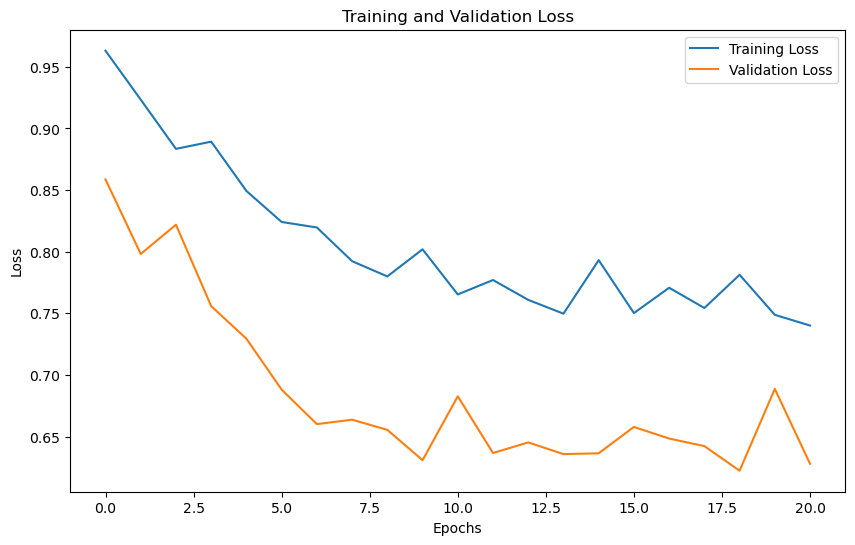

In [6]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
# get predictions on train and test
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [8]:
# inverse transform data
y_test = std_scaler.inverse_transform(y_test)
train_predictions = std_scaler.inverse_transform(train_predictions)
test_predictions = std_scaler.inverse_transform(test_predictions)

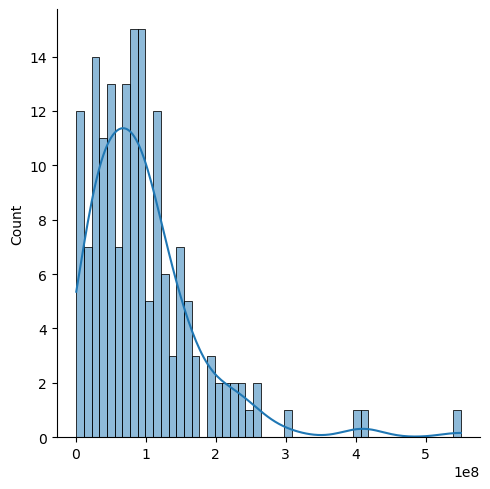

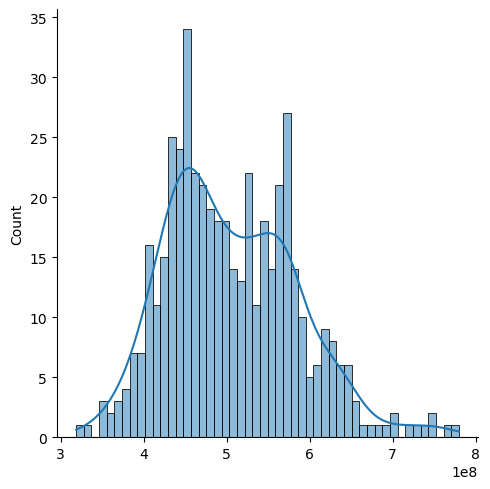

In [9]:

test_mae_loss = np.mean(np.abs(test_predictions - y_test), axis=1)
sns.displot(test_mae_loss, bins=50, kde=True)

train_mae_loss = np.mean(np.abs(train_predictions - y_train), axis=1)
sns.displot(train_mae_loss, bins=50, kde=True)

In [10]:
path = "anomalous_points_alex3.pkl"
with open(path, "rb") as f:
    anom_alex = pickle.load(f)

anom_alex -= 6276
print(anom_alex)

[  4   5  14  27  38  46  75  76 139 160]


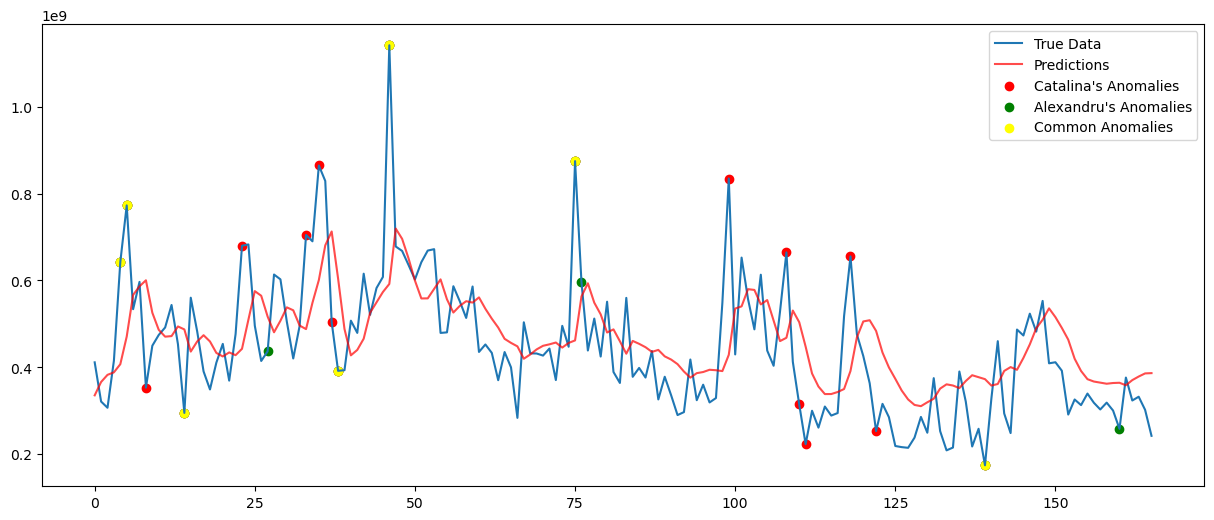

In [14]:
# Calculate loss
loss = np.mean(np.abs(test_predictions - y_test), axis=1)

threshold = np.mean(loss) + np.std(loss)
anom_cata = loss > threshold
anom_alex_plot = np.zeros(len(loss), dtype=bool)
for i in anom_alex:
    anom_alex_plot[i] = True

anom_comb = [a and b for a, b in zip(anom_cata, anom_alex_plot)]

# Visualize the results
plt.figure(figsize=(15, 6))
plt.plot(range(len(y_test)), y_test, label='True Data')
plt.plot(range(len(test_predictions)), test_predictions, label='Predictions', alpha=0.7, color='red')
plt.scatter(np.where(anom_cata)[0], y_test[anom_cata], color='red', label="Catalina's Anomalies")
plt.scatter(np.where(anom_alex_plot)[0], y_test[anom_alex_plot], color='green', label="Alexandru's Anomalies")
plt.scatter(np.where(anom_comb)[0], y_test[anom_comb], color='yellow', label='Common Anomalies')
plt.legend()
plt.show()